# Cornac Examples
> Multiple examples showcasing the features of cornac library and recommender concepts

- toc: true
- badges: true
- comments: true
- categories: [Cornac]
- author: "<a href='https://nbviewer.jupyter.org/github/PreferredAI/tutorials/tree/master/recommender-systems/'>Cornac</a>"
- image:

In [ ]:
!pip install -q -U cornac

     |████████████████████████████████| 13.4MB 194kB/s 


In [ ]:
import cornac
cornac.__version__

'1.4.1'

In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, sparse

from cornac.data import Reader
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN
from cornac.models import MF, NMF, BaselineOnly
from cornac.models import BPR, WMF
from cornac.models import GMF, MLP, NeuMF, VAECF, WMF

%tensorflow_version 1.x

## EDA

In [ ]:
df_100k3 = pd.read_csv('./data/ml-100k/ratings.csv',
                 usecols=["UserId","MovieId","Rating"])
df_100k3.columns = ["user_id", "item_id", "rating"]
df_100k3.head()

,user_id,item_id,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [ ]:
df_user_100k = pd.read_csv('./data/ml-100k/users.csv').set_index("UserID")
df_user_100k.head()

,Age,Gender,Occupation,Zip Code
UserID,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


In [ ]:
df_item_100k = pd.read_csv('./data/ml-100k/items.csv').set_index("ItemID").drop(columns=["Video Release Date", "IMDb URL", "unknown"])
df_item_100k.head()

,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


Rating distribution

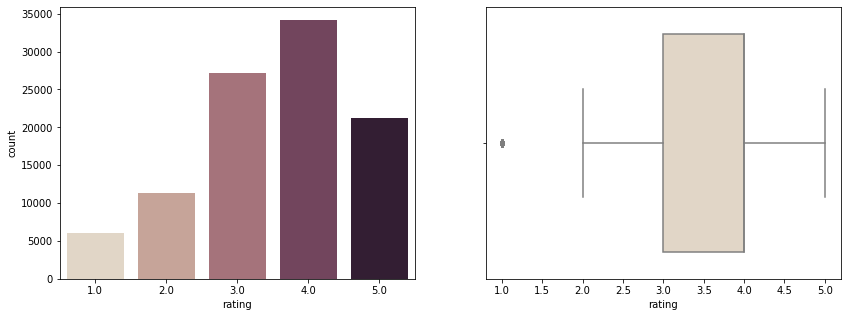

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.countplot(x="rating", data=df, palette="ch:.25", ax=axes[0])
sns.boxplot(x="rating", data=df, palette="ch:.25", ax=axes[1])

Sparsity

In [ ]:
def print_sparsity(df):
  n_users = df.user_id.nunique()
  n_items = df.item_id.nunique()
  n_ratings = len(df)
  rating_matrix_size = n_users * n_items
  sparsity = 1 - n_ratings / rating_matrix_size

  print(f"Number of users: {n_users}")
  print(f"Number of items: {n_items}")
  print(f"Number of available ratings: {n_ratings}")
  print(f"Number of all possible ratings: {rating_matrix_size}")
  print("-" * 40)
  print(f"SPARSITY: {sparsity * 100.0:.2f}%")

print_sparsity(df_100k3)

Number of users: 943
Number of items: 1682
Number of available ratings: 100000
Number of all possible ratings: 1586126
----------------------------------------
SPARSITY: 93.70%


For this MovieLens dataset, the data has been prepared in such a way that each user has at least 20 ratings. As a result, it's relatively dense as compared to many other recommendation datasets that are usually much sparser (often 99% or more).

Power Law Distribution

In [ ]:
item_rate_count = df_100k3.groupby("item_id")["user_id"].nunique().sort_values(ascending=False)

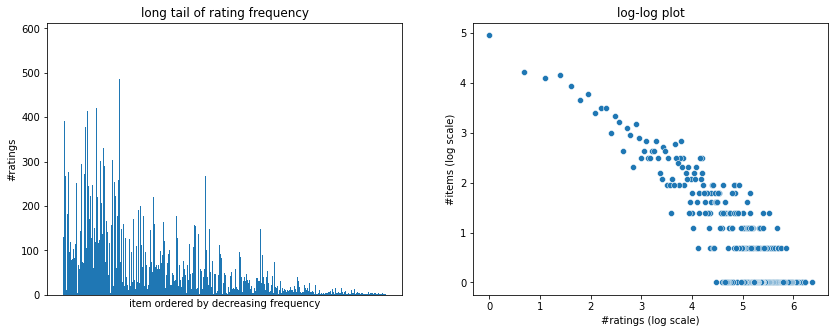

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
axes[0].bar(x=item_rate_count.index, height=item_rate_count.values, width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency", 
            xlabel="item ordered by decreasing frequency", 
            ylabel="#ratings")

count = item_rate_count.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)");

User profiling

In [ ]:
dataset = cornac.data.Dataset.from_uir(df.itertuples(index=False))
uknn_pearson = UserKNN(k=50, similarity="pearson", name="UserKNN-Pearson", verbose=False).fit(dataset)

uknn_pearson.train_set.uid_map[1]

118

In [ ]:
def user_profiling(UID, df, user_df, item_df, TOPK=5):
  dataset = cornac.data.Dataset.from_uir(df.itertuples(index=False))
  uknn_pearson = UserKNN(k=50, similarity="pearson", name="UserKNN-Pearson", verbose=False).fit(dataset)

  rating_mat = uknn_pearson.train_set.matrix
  user_id2idx = uknn_pearson.train_set.uid_map
  user_idx2id = list(uknn_pearson.train_set.user_ids)
  item_id2idx = uknn_pearson.train_set.iid_map
  item_idx2id = list(uknn_pearson.train_set.item_ids)

  UIDX = uknn_pearson.train_set.uid_map[UID]

  print(f"UserID = {UID}")
  print("-" * 25)
  print(user_df.loc[UID])

  rating_arr = rating_mat[UIDX].A.ravel()
  top_rated_items = np.argsort(rating_arr)[-TOPK:]
  print(f"\nTOP {TOPK} RATED ITEMS BY USER {UID}:")
  print(item_df.loc[[int(item_idx2id[i]) for i in top_rated_items]])

user_profiling(2, df_100k3, df_user_100k, df_item_100k)

UserID = 2
-------------------------
Age              53
Gender            F
Occupation    other
Zip Code      94043
Name: 2, dtype: object

TOP 5 RATED ITEMS BY USER 2:
                                Title Release Date  ...  War  Western
ItemID                                              ...              
50                   Star Wars (1977)  01-Jan-1977  ...    1        0
251            Shall We Dance? (1996)  11-Jul-1997  ...    0        0
272          Good Will Hunting (1997)  01-Jan-1997  ...    0        0
311     Wings of the Dove, The (1997)  01-Jan-1997  ...    0        0
242                      Kolya (1996)  24-Jan-1997  ...    0        0

[5 rows x 20 columns]


## Recomendations based on item popularity

Since some items are much more popular than the rest, intuitively many users may prefer these popular items. From that observation, it inspires a simple approach for providing recommendations based on popularity (i.e., number of ratings) of the items.

In [ ]:
'''Let's do a simple experiment with the popularity approach. In this 
experiment, we will split the rating data into 5 folds for cross-validation. 
For each run, 4 folds will be used for training and the remaining fold will 
be used for evaluation. We measure the recommendation performance using 
Recall@20 metric.'''

def itempop_cornac(df):
  df = df.astype({'user_id':object, 'item_id':object})
  records = df.to_records(index=False)
  result = list(records)
  eval_method = cornac.eval_methods.CrossValidation(result, n_folds=5, seed=42) # 5-fold cross validation
  most_pop = cornac.models.MostPop() # recommender system based on item popularity
  rec_20 = cornac.metrics.Recall(k=20) # recall@20 metric
  cornac.Experiment(eval_method=eval_method, models=[most_pop], metrics=[rec_20]).run() # put everything together into an experiment

itempop_cornac(df_100k3)


TEST:
...
[MostPop]
       | Recall@20 | Train (s) | Test (s)
------ + --------- + --------- + --------
Fold 0 |    0.1263 |    0.0054 |   0.4017
Fold 1 |    0.1304 |    0.0053 |   0.3883
Fold 2 |    0.1337 |    0.0055 |   0.4014
Fold 3 |    0.1252 |    0.0058 |   0.4019
Fold 4 |    0.1187 |    0.0054 |   0.4046
------ + --------- + --------- + --------
Mean   |    0.1269 |    0.0055 |   0.3996
Std    |    0.0051 |    0.0002 |   0.0058



## User-based collaborative filtering

In [ ]:
def userknn_cornac(df):
  df = df.astype({'user_id':object, 'item_id':object})
  records = df.to_records(index=False)
  result = list(records)
  K = 50  # number of nearest neighbors
  VERBOSE = False
  SEED = 42
  uknn_cosine = UserKNN(k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE)
  uknn_cosine_mc = UserKNN(k=K, similarity="cosine", mean_centered=True, name="UserKNN-Cosine-MC", verbose=VERBOSE)
  uknn_pearson = UserKNN(k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE)
  uknn_pearson_mc = UserKNN(k=K, similarity="pearson", mean_centered=True, name="UserKNN-Pearson-MC", verbose=VERBOSE)
  ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
  cornac.Experiment(eval_method=ratio_split,
                    models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
                    metrics=[cornac.metrics.RMSE()],
                    ).run()

userknn_cornac(df_100k3)


TEST:
...
                   |   RMSE | Train (s) | Test (s)
------------------ + ------ + --------- + --------
UserKNN-Cosine     | 0.9102 |    0.1444 |   1.3036
UserKNN-Cosine-MC  | 0.8947 |    0.1369 |   1.2839
UserKNN-Pearson    | 0.8947 |    0.1458 |   1.2950
UserKNN-Pearson-MC | 0.8947 |    0.1360 |   1.2894



## Item-based collaborative filtering

In [ ]:
def itemknn_cornac(df):
  df = df.astype({'user_id':object, 'item_id':object})
  records = df.to_records(index=False)
  result = list(records)
  K = 50  # number of nearest neighbors
  VERBOSE = False
  SEED = 42
  iknn_cosine = ItemKNN(k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE)
  iknn_cosine_mc = ItemKNN(k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=VERBOSE)
  iknn_pearson = ItemKNN(k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE)
  iknn_pearson_mc = ItemKNN(k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=VERBOSE)
  ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
  cornac.Experiment(eval_method=ratio_split,
                    models=[iknn_cosine, iknn_cosine_mc, iknn_pearson, iknn_pearson_mc],
                    metrics=[cornac.metrics.RMSE()],
                    ).run()

itemknn_cornac(df_100k3)


TEST:
...
                       |   RMSE | Train (s) | Test (s)
---------------------- + ------ + --------- + --------
ItemKNN-Cosine         | 0.9687 |    0.2175 |   1.3857
ItemKNN-AdjustedCosine | 0.9099 |    0.2107 |   1.4040
ItemKNN-Pearson        | 0.9624 |    0.2462 |   1.3763
ItemKNN-Pearson-MC     | 0.9573 |    0.2374 |   1.3883



## Matrix factorization

In [ ]:
def mf_cornac(df):
  df = df.astype({'user_id':object, 'item_id':object})
  records = df.to_records(index=False)
  result = list(records)
  K = 100
  VERBOSE = False
  SEED = 42
  lbd = 0.01
  baseline = BaselineOnly(max_iter=20, learning_rate=0.01, lambda_reg=lbd, verbose=VERBOSE)
  mf1 = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.0, use_bias=False, verbose=VERBOSE, seed=SEED, name=f"MF(K={K})")
  mf2 = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=lbd, use_bias=False, verbose=VERBOSE, seed=SEED, name=f"MF(K={K},lambda={lbd:.4f})")
  mf3 = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=lbd, use_bias=True, verbose=VERBOSE, seed=SEED, name=f"MF(K={K},bias)")
  nmf = NMF(k=K, max_iter=200, learning_rate=0.01, use_bias=False, verbose=VERBOSE, seed=SEED, name=f"NMF(K={K})")
  ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
  cornac.Experiment(eval_method=ratio_split,
                    models=[baseline, mf1, mf2, mf3, nmf],
                    metrics=[cornac.metrics.RMSE()],
                    ).run()

mf_cornac(df_100k3)


TEST:
...
                        |   RMSE | Train (s) | Test (s)
----------------------- + ------ + --------- + --------
BaselineOnly            | 0.8892 |    0.0113 |   0.2159
MF(K=100)               | 0.8665 |    0.5043 |   0.2463
MF(K=100,lambda=0.0100) | 0.8647 |    0.5154 |   0.2466
MF(K=100,bias)          | 0.8614 |    0.5224 |   0.2324
NMF(K=100)              | 0.8807 |    8.7957 |   0.2519



## Implicit matrix factorization

In [ ]:
def implicitmf_cornac(df):
  df = df.astype({'user_id':object, 'item_id':object})
  records = df.to_records(index=False)
  result = list(records)

  K = 50
  VERBOSE = False
  SEED = 42
  mf = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, verbose=VERBOSE, seed=SEED, name=f"MF(K={K})")
  wmf = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01, verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")
  bpr = BPR(k=K, max_iter=200, learning_rate=0.01, lambda_reg=0.001, verbose=VERBOSE, seed=SEED, name=f"BPR(K={K})")

  eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=10),
  cornac.metrics.Recall(k=10),
  cornac.metrics.FMeasure(k=10),
  cornac.metrics.NDCG(k=[10, 20, 30]),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
  ]

  rs = RatioSplit(result, test_size=0.2, seed=SEED, verbose=VERBOSE)

  cornac.Experiment(eval_method=rs,
                    models=[mf, wmf, bpr],
                    metrics=eval_metrics,
                    ).run()

implicitmf_cornac(df_100k3)


TEST:
...
          |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) | Test (s)
--------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + --------
MF(K=50)  | 0.8909 | 0.6573 | 0.0290 | 0.0402 | 0.1453 |  0.0539 |  0.0565 |  0.0626 |       0.0524 |    0.0241 |    0.2498 |   2.0077
WMF(K=50) | 1.1012 | 0.8980 | 0.0734 | 0.0956 | 0.2387 |  0.1068 |  0.1292 |  0.1506 |       0.0968 |    0.0800 |    6.4536 |   2.1959
BPR(K=50) | 1.5631 | 0.9356 | 0.0859 | 0.1146 | 0.2337 |  0.1096 |  0.1393 |  0.1662 |       0.0938 |    0.1000 |    6.5871 |   1.9878



As we can observe, the strength of the MF model is the ability to predict ratings well (lower RMSE). However, WMF model is designed to rank items, by fitting binary adoptions, thus it outperforms MF across all the listed ranking metrics.

BPR only tries to preserve the ordinal constraints without learning to predict the rating values. Thus, RMSE is not the right metric to evaluate BPR model. Minimizing the loss function of BPR is analogous to maximizing AUC, therefore, we expect BPR to do well on that metric.

Both BPR and WMF models are designed to obtain good performances in terms of ranking metrics. With reasonable efforts for hyper-parameter tuning, we should see comparable performance between the two models.

## Neural Collaborative Filtering
Neural collaborative filtering consists of a family of models developed based on neural networks to tackle the problem of collaborative filtering based on implicit feedback. The final model NeuMF is a combination of two components, namely Generalized Matrix Factorization (GMF) and Multi-Layer Perceptrons (MLP), which are also independent models respectively.

In [ ]:
GMF_FACTORS = 8  # @param
MLP_LAYERS = [32, 16, 8]  # @param
ACTIVATION = "tanh"  # @param ["tanh", "sigmoid", "relu", "leaky_relu"]
NEG_SAMPLES = 3  # @param
NUM_EPOCHS = 10  # @param 
BATCH_SIZE = 256  # @param
LEARNING_RATE = 0.001  # @param

In [ ]:
gmf = GMF(num_factors=GMF_FACTORS, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, 
          num_neg=NEG_SAMPLES, lr=LEARNING_RATE, seed=SEED, verbose=VERBOSE)
mlp = MLP(layers=MLP_LAYERS, act_fn=ACTIVATION, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, 
          num_neg=NEG_SAMPLES, lr=LEARNING_RATE, seed=SEED, verbose=VERBOSE)
neumf = NeuMF(num_factors=GMF_FACTORS, layers=MLP_LAYERS, act_fn=ACTIVATION, num_epochs=NUM_EPOCHS,
              num_neg=NEG_SAMPLES, batch_size=BATCH_SIZE, lr=LEARNING_RATE, seed=SEED, verbose=VERBOSE)

wmf = WMF(k=GMF_FACTORS, max_iter=200, learning_rate=0.001, seed=SEED, verbose=VERBOSE)

ml_100k = movielens.load_feedback(variant="100K", reader=Reader(bin_threshold=4.0))
ratio_split = RatioSplit(
  data=ml_100k, test_size=0.2, exclude_unknowns=True, seed=SEED, verbose=VERBOSE
)
ndcg_50 = cornac.metrics.NDCG(k=50)
rec_50 = cornac.metrics.Recall(k=50)

cornac.Experiment(
  eval_method=ratio_split,
  models=[gmf, mlp, neumf, wmf],
  metrics=[ndcg_50, rec_50],
).run()

Data from http://files.grouplens.org/datasets/movielens/ml-100k/u.data
will be cached into /root/.cornac/ml-100k/u.data



File cached!

TEST:
...
      | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------- + --------- + --------- + --------
GMF   |  0.1609 |    0.2778 |   28.6248 |   1.0193
MLP   |  0.1630 |    0.2807 |   29.0589 |   1.1897
NeuMF |  0.2412 |    0.4268 |   29.9544 |   1.2884
WMF   |  0.1976 |    0.3753 |    9.2373 |   0.5958



## Variational Autoencoder for Collaborative Filtering (VAECF)
Variational Autoencoders (VAE) is a type of autoencoders which is a neural network with auto-associative mapping of inputs. Normal autoencoders learns a determinisic latent representation of an input, while VAE learns a distribution of that representation. VAECF model extends VAE for the collaborative filtering problem with implicit feedback data.

In [ ]:
NUM_FACTORS = 25  # @param
AE_LAYERS = [100, 50]  # @param
ACTIVATION = "tanh"  # @param ["tanh", "sigmoid", "relu", "leaky_relu"]
LIKELIHOOD = "bern"  # @param ["bern", "mult", "gaus", "pois"]
NUM_EPOCHS = 600  # @param 
BATCH_SIZE = 256  # @param
LEARNING_RATE = 0.001  # @param

In [ ]:
vaecf = VAECF(k=NUM_FACTORS, autoencoder_structure=AE_LAYERS, act_fn=ACTIVATION,
              likelihood=LIKELIHOOD, n_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
              learning_rate=LEARNING_RATE, seed=SEED, verbose=VERBOSE, use_gpu=True)

wmf = WMF(k=NUM_FACTORS, max_iter=200, learning_rate=0.001, seed=SEED, verbose=VERBOSE)

ml_100k = movielens.load_feedback(variant="100K", reader=Reader(bin_threshold=4.0))
ratio_split = RatioSplit(
  data=ml_100k, test_size=0.2, exclude_unknowns=True, seed=SEED, verbose=VERBOSE
)

cornac.Experiment(
  eval_method=ratio_split, models=[vaecf, wmf], metrics=[rec_50, ndcg_50],
).run()


TEST:
...
      | NDCG@50 | Recall@50 | Train (s) | Test (s)
----- + ------- + --------- + --------- + --------
VAECF |  0.2418 |    0.4268 |   56.6568 |   1.0349
WMF   |  0.2045 |    0.3958 |   10.5690 |   0.6070



## Running Experiment

In [ ]:
import cornac
from cornac.eval_methods import RatioSplit
from cornac.models import MF, PMF, BPR
from cornac.metrics import MAE, RMSE, Precision, Recall, NDCG, AUC

# load the built-in MovieLens 100K and split the data based on ratio
ml_100k = cornac.datasets.movielens.load_feedback()
rs = RatioSplit(data=ml_100k, test_size=0.2, rating_threshold=4.0, seed=123)

# initialize models, here we are comparing: Biased MF, PMF, and BPR
models = [
    MF(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02, use_bias=True, seed=123),
    PMF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.001, seed=123),
    BPR(k=10, max_iter=200, learning_rate=0.001, lambda_reg=0.01, seed=123),
]

# define metrics to evaluate the models
metrics = [MAE(), RMSE(), Precision(k=10), Recall(k=10), NDCG(k=10), AUC()]

# put it together in an experiment, voilà!
cornac.Experiment(eval_method=rs, models=models, metrics=metrics, user_based=True).run()


TEST:
...
    |    MAE |   RMSE |    AUC | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
--- + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
MF  | 0.7430 | 0.8998 | 0.7445 |  0.0479 |       0.0437 |    0.0352 |    0.1202 |   1.4422
PMF | 0.7534 | 0.9138 | 0.7744 |  0.0617 |       0.0533 |    0.0479 |    2.2300 |   1.7559
BPR | 2.0143 | 2.2267 | 0.8695 |  0.0975 |       0.0727 |    0.0891 |    3.8556 |   1.4108



## PMF ratio
Example to run Probabilistic Matrix Factorization (PMF) model with Ratio Split evaluation strategy

In [ ]:
import cornac
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import PMF


# Load the MovieLens 100K dataset
ml_100k = movielens.load_feedback()

# Instantiate an evaluation method.
ratio_split = RatioSplit(
    data=ml_100k, test_size=0.2, rating_threshold=4.0, exclude_unknowns=False
)

# Instantiate a PMF recommender model.
pmf = PMF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.001)

# Instantiate evaluation metrics.
mae = cornac.metrics.MAE()
rmse = cornac.metrics.RMSE()
rec_20 = cornac.metrics.Recall(k=20)
pre_20 = cornac.metrics.Precision(k=20)

# Instantiate and then run an experiment.
cornac.Experiment(
    eval_method=ratio_split,
    models=[pmf],
    metrics=[mae, rmse, rec_20, pre_20],
    user_based=True,
).run()


TEST:
...
    |    MAE |   RMSE | Precision@20 | Recall@20 | Train (s) | Test (s)
--- + ------ + ------ + ------------ + --------- + --------- + --------
PMF | 0.7408 | 0.8992 |       0.0502 |    0.0903 |    2.2457 |   1.2484



## Given data
Example on how to train and evaluate a model with provided train and test sets

In [ ]:
from cornac.data import Reader
from cornac.eval_methods import BaseMethod
from cornac.models import MF
from cornac.metrics import MAE, RMSE
from cornac.utils import cache


# Download MovieLens 100K provided train and test sets
reader = Reader()
train_data = reader.read(
    cache(url="http://files.grouplens.org/datasets/movielens/ml-100k/u1.base")
)
test_data = reader.read(
    cache(url="http://files.grouplens.org/datasets/movielens/ml-100k/u1.test")
)

# Instantiate a Base evaluation method using the provided train and test sets
eval_method = BaseMethod.from_splits(
    train_data=train_data, test_data=test_data, exclude_unknowns=False, verbose=True
)

# Instantiate the MF model
mf = MF(
    k=10,
    max_iter=25,
    learning_rate=0.01,
    lambda_reg=0.02,
    use_bias=True,
    early_stop=True,
    verbose=True,
)

# Evaluation
test_result, val_result = eval_method.evaluate(
    model=mf, metrics=[MAE(), RMSE()], user_based=True
)
print(test_result)

0.00B [00:00, ?B/s]

Data from http://files.grouplens.org/datasets/movielens/ml-100k/u1.base
will be cached into /root/.cornac/u1.base


1.60MB [00:00, 2.19MB/s]                           
0.00B [00:00, ?B/s]

File cached!
Data from http://files.grouplens.org/datasets/movielens/ml-100k/u1.test
will be cached into /root/.cornac/u1.test


401kB [00:00, 852kB/s]                            


File cached!
rating_threshold = 1.0
exclude_unknowns = False
---

 72%|███████▏  | 18/25 [00:00<00:00, 140.99it/s, loss=32731.62]


Training data:
Number of users = 943
Number of items = 1650
Number of ratings = 80000
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 459
Number of items = 1410
Number of ratings = 20000
Number of unknown users = 0
Number of unknown items = 32
---
Total users = 943
Total items = 1682

[MF] Training started!


100%|██████████| 25/25 [00:00<00:00, 129.03it/s, loss=28517.47]


Optimization finished!

[MF] Evaluation started!
   |    MAE |   RMSE | Train (s) | Test (s)
-- + ------ + ------ + --------- + --------
MF | 0.7447 | 0.9166 |    0.1995 |   0.6030



## C2PF

Collaborative Context Poisson Factorization (C2PF) with Amazon Office dataset.

In [ ]:
"""Fit to and evaluate C2PF [1] on the Office Amazon dataset.
[1] Salah, Aghiles, and Hady W. Lauw. A Bayesian Latent Variable Model of User Preferences with Item Context. \
    In IJCAI, pp. 2667-2674. 2018.
"""

from cornac.data import GraphModality
from cornac.eval_methods import RatioSplit
from cornac.experiment import Experiment
from cornac import metrics
from cornac.models import C2PF
from cornac.datasets import amazon_office as office


# In addition to user-item feedback, C2PF integrates item-to-item contextual relationships
# The necessary data can be loaded as follows
ratings = office.load_feedback()
contexts = office.load_graph()

# Instantiate a GraphModality, it makes it convenient to work with graph (network) auxiliary information
# For more details, please refer to the tutorial on how to work with auxiliary data
item_graph_modality = GraphModality(data=contexts)

# Define an evaluation method to split feedback into train and test sets
ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2,
    rating_threshold=3.5,
    exclude_unknowns=True,
    verbose=True,
    item_graph=item_graph_modality,
)

# Instantiate C2PF
c2pf = C2PF(k=100, max_iter=80, variant="c2pf")

# Evaluation metrics
ndcg = metrics.NDCG(k=-1)
mrr = metrics.MRR()
rec = metrics.Recall(k=20)
pre = metrics.Precision(k=20)

# Put everything together into an experiment and run it
Experiment(eval_method=ratio_split, models=[c2pf], metrics=[ndcg, mrr, rec, pre]).run()

0.00B [00:00, ?B/s]

Data from https://static.preferred.ai/cornac/datasets/amazon_office/rating.zip
will be cached into /root/.cornac/amazon_office/rating.txt


213kB [00:01, 171kB/s]                            
0.00B [00:00, ?B/s]

Unzipping ...
File cached!
Data from https://static.preferred.ai/cornac/datasets/amazon_office/context.zip
will be cached into /root/.cornac/amazon_office/context.txt


344kB [00:01, 271kB/s]                            


Unzipping ...
File cached!
rating_threshold = 3.5
exclude_unknowns = True
---
Training data:
Number of users = 3698
Number of items = 6405
Number of ratings = 42625
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 3269
Number of items = 3549
Number of ratings = 10404
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 3698
Total items = 6405

[C2PF] Training started!
Learning...
Learning completed!


  0%|          | 0/3269 [00:00<?, ?it/s]


[C2PF] Evaluation started!


100%|██████████| 3269/3269 [00:09<00:00, 350.86it/s]



TEST:
...
     |    MRR | NDCG@-1 | Precision@20 | Recall@20 | Train (s) | Test (s)
---- + ------ + ------- + ------------ + --------- + --------- + --------
C2PF | 0.0611 |  0.1913 |       0.0136 |    0.0868 | 1314.9453 |   9.3316



## Hyperparameters

In [ ]:
"""Example for hyper-parameter searching with Matrix Factorization"""

import numpy as np
import cornac
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.hyperopt import Discrete, Continuous
from cornac.hyperopt import GridSearch, RandomSearch


# Load MovieLens 100K ratings
ml_100k = movielens.load_feedback(variant="100K")

# Define an evaluation method to split feedback into train, validation and test sets
ratio_split = RatioSplit(data=ml_100k, test_size=0.1, val_size=0.1, verbose=True)

# Instantiate MAE and RMSE for evaluation
mae = cornac.metrics.MAE()
rmse = cornac.metrics.RMSE()

# Define a base MF model with fixed hyper-parameters
mf = cornac.models.MF(max_iter=20, learning_rate=0.01, early_stop=True, verbose=True)

# Wrap MF model inside GridSearch along with the searching space
gs_mf = GridSearch(
    model=mf,
    space=[
        Discrete("k", [10, 30, 50]),
        Discrete("use_bias", [True, False]),
        Discrete("lambda_reg", [1e-1, 1e-2, 1e-3, 1e-4]),
    ],
    metric=rmse,
    eval_method=ratio_split,
)

# Wrap MF model inside RandomSearch along with the searching space, try 30 times
rs_mf = RandomSearch(
    model=mf,
    space=[
        Discrete("k", [10, 30, 50]),
        Discrete("use_bias", [True, False]),
        Continuous("lambda_reg", low=1e-4, high=1e-1),
    ],
    metric=rmse,
    eval_method=ratio_split,
    n_trails=30,
)

# Put everything together into an experiment and run it
cornac.Experiment(
    eval_method=ratio_split,
    models=[gs_mf, rs_mf],
    metrics=[mae, rmse],
    user_based=False,
).run()

rating_threshold = 1.0
exclude_unknowns = True


 75%|███████▌  | 15/20 [00:00<00:00, 113.22it/s, loss=31685.08]

---
Training data:
Number of users = 943
Number of items = 1656
Number of ratings = 80000
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 925
Number of items = 1254
Number of ratings = 9984
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 922
Number of items = 1235
Number of ratings = 9988
---
Total users = 943
Total items = 1656

[GridSearch_MF] Training started!
Evaluating: {'k': 10, 'lambda_reg': 0.0001, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 117.48it/s, loss=28069.14]


Optimization finished!


100%|██████████| 20/20 [00:00<00:00, 135.92it/s, loss=29540.58]

Evaluating: {'k': 10, 'lambda_reg': 0.0001, 'use_bias': True}
Optimization finished!



100%|██████████| 20/20 [00:00<00:00, 138.72it/s, loss=28466.41]

Evaluating: {'k': 10, 'lambda_reg': 0.001, 'use_bias': False}
Optimization finished!



100%|██████████| 20/20 [00:00<00:00, 122.73it/s, loss=29679.09]

Evaluating: {'k': 10, 'lambda_reg': 0.001, 'use_bias': True}
Optimization finished!



100%|██████████| 20/20 [00:00<00:00, 134.49it/s, loss=29168.98]

Evaluating: {'k': 10, 'lambda_reg': 0.01, 'use_bias': False}
Optimization finished!



100%|██████████| 20/20 [00:00<00:00, 122.54it/s, loss=30386.51]

Evaluating: {'k': 10, 'lambda_reg': 0.01, 'use_bias': True}
Optimization finished!



100%|██████████| 20/20 [00:00<00:00, 138.90it/s, loss=33891.18]

Evaluating: {'k': 10, 'lambda_reg': 0.1, 'use_bias': False}
Optimization finished!



100%|██████████| 20/20 [00:00<00:00, 129.45it/s, loss=33907.84]

Evaluating: {'k': 10, 'lambda_reg': 0.1, 'use_bias': True}
Optimization finished!



 75%|███████▌  | 15/20 [00:00<00:00, 80.51it/s, loss=30235.88]

Evaluating: {'k': 30, 'lambda_reg': 0.0001, 'use_bias': False}


 15%|█▌        | 3/20 [00:00<00:00, 82.12it/s, loss=35532.26]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.0001, 'use_bias': True}


100%|██████████| 20/20 [00:00<00:00, 78.13it/s, loss=26479.67]


Optimization finished!


 80%|████████  | 16/20 [00:00<00:00, 84.55it/s, loss=29081.02]

Evaluating: {'k': 30, 'lambda_reg': 0.001, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 80.98it/s, loss=24763.03]


Optimization finished!


 80%|████████  | 16/20 [00:00<00:00, 80.95it/s, loss=30655.64]

Evaluating: {'k': 30, 'lambda_reg': 0.001, 'use_bias': True}


 10%|█         | 2/20 [00:00<00:00, 90.06it/s, loss=252966.80]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.01, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 74.03it/s, loss=26736.58]


Optimization finished!


 80%|████████  | 16/20 [00:00<00:00, 83.59it/s, loss=31441.78]

Evaluating: {'k': 30, 'lambda_reg': 0.01, 'use_bias': True}


100%|██████████| 20/20 [00:00<00:00, 81.56it/s, loss=28064.21]


Optimization finished!


 85%|████████▌ | 17/20 [00:00<00:00, 90.88it/s, loss=34440.27]

Evaluating: {'k': 30, 'lambda_reg': 0.1, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 86.20it/s, loss=33572.37]


Optimization finished!


 80%|████████  | 16/20 [00:00<00:00, 85.06it/s, loss=33991.67]

Evaluating: {'k': 30, 'lambda_reg': 0.1, 'use_bias': True}


  5%|▌         | 1/20 [00:00<00:00, 68.43it/s, loss=546675.25]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.0001, 'use_bias': False}


  5%|▌         | 1/20 [00:00<00:00, 68.89it/s, loss=41469.27]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.0001, 'use_bias': True}


100%|██████████| 20/20 [00:00<00:00, 60.71it/s, loss=24302.16]


Optimization finished!


 55%|█████▌    | 11/20 [00:00<00:00, 63.89it/s, loss=33206.38]

Evaluating: {'k': 50, 'lambda_reg': 0.001, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 54.75it/s, loss=23045.52]


Optimization finished!


 60%|██████    | 12/20 [00:00<00:00, 66.91it/s, loss=33009.37]

Evaluating: {'k': 50, 'lambda_reg': 0.001, 'use_bias': True}


100%|██████████| 20/20 [00:00<00:00, 63.26it/s, loss=24565.52]


Optimization finished!


 50%|█████     | 10/20 [00:00<00:00, 53.04it/s, loss=34417.25]

Evaluating: {'k': 50, 'lambda_reg': 0.01, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 55.37it/s, loss=24783.99]


Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.01, 'use_bias': True}


100%|██████████| 20/20 [00:00<00:00, 55.83it/s, loss=26360.77]


Optimization finished!


 60%|██████    | 12/20 [00:00<00:00, 59.66it/s, loss=35750.37]

Evaluating: {'k': 50, 'lambda_reg': 0.1, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 58.32it/s, loss=33372.11]


Optimization finished!


 55%|█████▌    | 11/20 [00:00<00:00, 61.39it/s, loss=34167.66]

Evaluating: {'k': 50, 'lambda_reg': 0.1, 'use_bias': True}


100%|██████████| 20/20 [00:00<00:00, 58.49it/s, loss=33779.37]


Optimization finished!
Best parameter settings: {'k': 50, 'lambda_reg': 0.01, 'use_bias': False}
RMSE = 0.9220

[GridSearch_MF] Evaluation started!


 75%|███████▌  | 15/20 [00:00<00:00, 79.16it/s, loss=33960.62]


[RandomSearch_MF] Training started!
Evaluating: {'k': 30, 'lambda_reg': 0.08612193189485716, 'use_bias': True}


 30%|███       | 6/20 [00:00<00:00, 141.43it/s, loss=38583.63]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.06501679843184538, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 100.55it/s, loss=33031.33]


Optimization finished!


 75%|███████▌  | 15/20 [00:00<00:00, 83.19it/s, loss=33864.39]

Evaluating: {'k': 30, 'lambda_reg': 0.0694755346230901, 'use_bias': True}


 15%|█▌        | 3/20 [00:00<00:00, 72.29it/s, loss=62142.05] 

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.08344455898777325, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 57.71it/s, loss=32557.79]


Optimization finished!


100%|██████████| 20/20 [00:00<00:00, 113.03it/s, loss=32853.84]

Evaluating: {'k': 10, 'lambda_reg': 0.06841850071431532, 'use_bias': False}
Optimization finished!



100%|██████████| 20/20 [00:00<00:00, 124.30it/s, loss=33150.24]

Evaluating: {'k': 10, 'lambda_reg': 0.05636623382282792, 'use_bias': True}
Optimization finished!



 70%|███████   | 14/20 [00:00<00:00, 76.65it/s, loss=35203.05]

Evaluating: {'k': 30, 'lambda_reg': 0.09375336481584197, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 73.56it/s, loss=33380.41]


Optimization finished!


 50%|█████     | 10/20 [00:00<00:00, 53.25it/s, loss=33705.49]

Evaluating: {'k': 50, 'lambda_reg': 0.003348765700165698, 'use_bias': True}


 10%|█         | 2/20 [00:00<00:00, 119.17it/s, loss=322194.56]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.04834871514338827, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 100.29it/s, loss=32004.79]


Optimization finished!


 50%|█████     | 10/20 [00:00<00:00, 54.17it/s, loss=34853.15]

Evaluating: {'k': 50, 'lambda_reg': 0.0293367690175802, 'use_bias': False}


 10%|█         | 2/20 [00:00<00:00, 114.57it/s, loss=36735.89]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.008332232500049594, 'use_bias': True}


100%|██████████| 20/20 [00:00<00:00, 103.31it/s, loss=30316.82]


Optimization finished!


 55%|█████▌    | 11/20 [00:00<00:00, 61.34it/s, loss=33973.71]

Evaluating: {'k': 50, 'lambda_reg': 0.05440617877888826, 'use_bias': True}


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.05911135478061436, 'use_bias': True}


100%|██████████| 20/20 [00:00<00:00, 69.46it/s, loss=32609.57]


Optimization finished!


 60%|██████    | 12/20 [00:00<00:00, 76.24it/s, loss=33982.51]

Evaluating: {'k': 30, 'lambda_reg': 0.06601038205965916, 'use_bias': True}


100%|██████████| 20/20 [00:00<00:00, 66.61it/s, loss=32986.09]


Optimization finished!


100%|██████████| 20/20 [00:00<00:00, 101.00it/s, loss=33249.00]

Evaluating: {'k': 10, 'lambda_reg': 0.08521209412017094, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 100.27it/s, loss=33249.00]


Optimization finished!


 95%|█████████▌| 19/20 [00:00<00:00, 107.30it/s, loss=29760.30]

Evaluating: {'k': 10, 'lambda_reg': 0.00035195130988261385, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 98.99it/s, loss=29069.75] 


Optimization finished!


100%|██████████| 20/20 [00:00<00:00, 106.21it/s, loss=30486.16]

Evaluating: {'k': 10, 'lambda_reg': 0.020650725560393792, 'use_bias': False}



 55%|█████▌    | 11/20 [00:00<00:00, 57.71it/s, loss=33524.53]

Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.009120595685760981, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 52.97it/s, loss=24341.06]


Optimization finished!


 70%|███████   | 14/20 [00:00<00:00, 74.48it/s, loss=33847.32]

Evaluating: {'k': 30, 'lambda_reg': 0.05819710438128485, 'use_bias': True}


 10%|█         | 2/20 [00:00<00:00, 87.17it/s, loss=251168.25] 

Optimization finished!
Evaluating: {'k': 30, 'lambda_reg': 0.003045882175220655, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 71.26it/s, loss=25421.24]


Optimization finished!
Evaluating: {'k': 50, 'lambda_reg': 0.021020313541605162, 'use_bias': True}


100%|██████████| 20/20 [00:00<00:00, 52.99it/s, loss=28414.02]


Optimization finished!


 50%|█████     | 10/20 [00:00<00:00, 51.96it/s, loss=36176.66]

Evaluating: {'k': 50, 'lambda_reg': 0.0931018404851425, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 50.41it/s, loss=32988.32]


Optimization finished!


100%|██████████| 20/20 [00:00<00:00, 108.93it/s, loss=28873.34]

Evaluating: {'k': 10, 'lambda_reg': 0.004135755775979635, 'use_bias': False}
Optimization finished!



 60%|██████    | 12/20 [00:00<00:00, 69.02it/s, loss=33869.27]

Evaluating: {'k': 30, 'lambda_reg': 0.040445801068814305, 'use_bias': True}


  5%|▌         | 1/20 [00:00<00:00, 132.08it/s, loss=41573.63]

Optimization finished!
Evaluating: {'k': 10, 'lambda_reg': 0.07677103563371872, 'use_bias': True}


100%|██████████| 20/20 [00:00<00:00, 110.49it/s, loss=33682.86]


Optimization finished!


 50%|█████     | 10/20 [00:00<00:00, 54.03it/s, loss=35032.48]

Evaluating: {'k': 50, 'lambda_reg': 0.03065512171145367, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 51.99it/s, loss=28106.60]


Optimization finished!


 75%|███████▌  | 15/20 [00:00<00:00, 77.31it/s, loss=31036.10]

Evaluating: {'k': 30, 'lambda_reg': 0.007274328332829502, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 74.36it/s, loss=26083.12]


Optimization finished!


 90%|█████████ | 18/20 [00:00<00:00, 95.74it/s, loss=32830.86]

Evaluating: {'k': 10, 'lambda_reg': 0.05198029254841431, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 87.32it/s, loss=32142.98]


Optimization finished!


 55%|█████▌    | 11/20 [00:00<00:00, 62.66it/s, loss=35979.21]

Evaluating: {'k': 50, 'lambda_reg': 0.09457717620040243, 'use_bias': False}


100%|██████████| 20/20 [00:00<00:00, 54.57it/s, loss=33207.05]


Optimization finished!


 65%|██████▌   | 13/20 [00:00<00:00, 72.72it/s, loss=33535.01]

Evaluating: {'k': 30, 'lambda_reg': 0.022599564709232942, 'use_bias': True}


100%|██████████| 20/20 [00:00<00:00, 68.46it/s, loss=29700.91]


Optimization finished!
Best parameter settings: {'k': 50, 'lambda_reg': 0.009120595685760981, 'use_bias': False}
RMSE = 0.9211

[RandomSearch_MF] Evaluation started!

VALIDATION:
...
                |    MAE |   RMSE | Time (s)
--------------- + ------ + ------ + --------
GridSearch_MF   | 0.7229 | 0.9220 |   0.1563
RandomSearch_MF | 0.7212 | 0.9211 |   0.1615

TEST:
...
                |    MAE |   RMSE | Train (s) | Test (s)
--------------- + ------ + ------ + --------- + --------
GridSearch_MF   | 0.7210 | 0.9217 |   11.4011 |   0.1963
RandomSearch_MF | 0.7227 | 0.9245 |   15.3778 |   0.2546



## Social BPR
Example for Social Bayesian Personalized Ranking (SBPR) with Epinions dataset

In [ ]:
import cornac
from cornac.data import Reader, GraphModality
from cornac.datasets import epinions
from cornac.eval_methods import RatioSplit


# SBPR integrates user social network into Bayesian Personalized Ranking.
# The necessary data can be loaded as follows
feedback = epinions.load_feedback(
    Reader(bin_threshold=4.0)
)  # feedback is binarised (turned into implicit) using Reader.
trust = epinions.load_trust()

# Instantiate a GraphModality, it makes it convenient to work with graph (network) auxiliary information
# For more details, please refer to the tutorial on how to work with auxiliary data
user_graph_modality = GraphModality(data=trust)

# Define an evaluation method to split feedback into train and test sets
ratio_split = RatioSplit(
    data=feedback,
    test_size=0.1,
    rating_threshold=0.5,
    exclude_unknowns=True,
    verbose=True,
    user_graph=user_graph_modality,
)

# Instantiate SBPR model
sbpr = cornac.models.SBPR(
    k=10,
    max_iter=50,
    learning_rate=0.001,
    lambda_u=0.015,
    lambda_v=0.025,
    lambda_b=0.01,
    verbose=True,
)

# Use Recall@10 for evaluation
rec_10 = cornac.metrics.Recall(k=10)

# Put everything together into an experiment and run it
cornac.Experiment(eval_method=ratio_split, models=[sbpr], metrics=[rec_10]).run()

0.00B [00:00, ?B/s]

Data from http://www.trustlet.org/datasets/downloaded_epinions/ratings_data.txt.bz2
will be cached into /root/.cornac/epinions/ratings_data.txt


2.62MB [00:01, 1.99MB/s]                            


Unzipping ...
File cached!


0.00B [00:00, ?B/s]

Data from http://www.trustlet.org/datasets/downloaded_epinions/trust_data.txt.bz2
will be cached into /root/.cornac/epinions/trust_data.txt


1.70MB [00:00, 2.19MB/s]                           


Unzipping ...
File cached!
rating_threshold = 0.5
exclude_unknowns = True
---
Training data:
Number of users = 37153
Number of items = 111967
Number of ratings = 445853
Max rating = 1.0
Min rating = 1.0
Global mean = 1.0
---
Test data:
Number of users = 16312
Number of items = 19302
Number of ratings = 41537
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 37153
Total items = 111967

[SBPR] Training started!


  0%|          | 0/16312 [00:00<?, ?it/s]

Optimization finished!

[SBPR] Evaluation started!


100%|██████████| 16312/16312 [05:16<00:00, 51.56it/s]


TEST:
...
     | Recall@10 | Train (s) | Test (s)
---- + --------- + --------- + --------
SBPR |    0.0183 |   40.7528 | 316.3553

